<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Univariate-Analysis,-Correlation-Based-MVPA,-Classifier-Based-MVPA" data-toc-modified-id="Univariate-Analysis,-Correlation-Based-MVPA,-Classifier-Based-MVPA-1">Univariate Analysis, Correlation-Based MVPA, Classifier-Based MVPA</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2">Setup</a></span></li><li><span><a href="#Load-post-processed-simulated-data" data-toc-modified-id="Load-post-processed-simulated-data-3">Load post-processed simulated data</a></span></li><li><span><a href="#Univariate-Analysis" data-toc-modified-id="Univariate-Analysis-4">Univariate Analysis</a></span><ul class="toc-item"><li><span><a href="#Visualize-our-data" data-toc-modified-id="Visualize-our-data-4.1">Visualize our data</a></span></li></ul></li><li><span><a href="#Correlation-Based-MVPA-and-Classifier-Based-MVPA" data-toc-modified-id="Correlation-Based-MVPA-and-Classifier-Based-MVPA-5">Correlation-Based MVPA and Classifier-Based MVPA</a></span><ul class="toc-item"><li><span><a href="#Visualize-our-data" data-toc-modified-id="Visualize-our-data-5.1">Visualize our data</a></span></li><li><span><a href="#Perform-MVPA-using-correlation" data-toc-modified-id="Perform-MVPA-using-correlation-5.2">Perform MVPA using correlation</a></span></li></ul></li><li><span><a href="#Perform-MVPA-using-classifier" data-toc-modified-id="Perform-MVPA-using-classifier-6">Perform MVPA using classifier</a></span></li></ul></div>

# Univariate Analysis, Correlation-Based MVPA, Classifier-Based MVPA

# Setup
Import Python dependencies necessary to run rest of the code.

In [1]:
# Import packages
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import svm
import warnings
warnings.filterwarnings('ignore')
import itertools
from tqdm import tqdm

In [2]:
# change default plotting
plt.rcParams.update({'font.size': 20, 'figure.figsize': (7,2)})

# make randomness reproducible
np.random.seed(0)

# convenience functions
def paired_cohen_d(x1,x2):
    meanDiff = np.mean(x1) - np.mean(x2)
    deltas   = x1 - x2;         # differences
    sdDeltas = np.std(deltas,ddof=1);  # standard deviation of the diffferences
    d        = np.abs(meanDiff / sdDeltas);   # Cohen's d (paired version)
    return d

# Load post-processed simulated data
Import our data. Look at how many subjects, trial conditions, and voxels we have to work with. 

Note that we follow Python conventions by numbering variables starting at 0 and not 1.

In [3]:
data = pd.read_csv('data.csv')

num_subjects = len(np.unique(data['sub_num']))
num_conditions = len(np.unique(data['cond']))
num_runs = len(np.unique(data['run']))
num_voxels = len(np.unique(data['vox']))

print('\n{} Subjects:\n'.format(num_subjects),np.unique(data['sub_num']))
print('\n{} Conditions (0=horror movie, 1=comedy):\n'.format(num_conditions),np.unique(data['cond']))
print('\n{} Runs (0=Even, 1=Odd):\n'.format(num_runs),np.unique(data['run']))
print('\n{} Voxels:\n'.format(num_voxels),np.unique(data['vox']))

display(data)


20 Subjects:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

2 Conditions (0=horror movie, 1=comedy):
 [0 1]

6 Runs (0=Even, 1=Odd):
 [0 1 2 3 4 5]

100 Voxels:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


sub_num  cond  run  vox  oddeven      beta
0            0     0    0    0        0 -1.913782
1            0     0    1    1        1  0.601825
2            0     0    2    2        0  0.465536
3            0     0    3    3        1  2.388045
4            0     0    4    4        0  2.679866
...        ...   ...  ...  ...      ...       ...
23995       19     1    1    4        1 -2.140837
23996       19     1    2    3        0  2.251580
23997       19     1    3    2        1  0.700867
23998       19     1    4    1        0  1.599539
23999       19     1    5    0        1 -2.620225

[24000 rows x 6 columns]

In [882]:
# ## Code for simulating the data: ##
import pymc3 as pm
import copy
def within3(y):
    x = copy.deepcopy(y)
    try:
        len(x)
    except:
        x = np.array([x])
    x[x>3] = x[x>3]-(3*2)
    x[x>3] = x[x>3]-(3*2)
    x[x<-3] = x[x<-3]+(3*2)
    return x
np.random.seed(0)
num_subjects = 20
num_conditions = 2
num_runs = 6
num_voxels = 100
data=[]

normal1 = pm.Normal.dist(mu=1,sigma=.65)
normal2 = pm.Normal.dist(mu=.5,sigma=.65)
unif = pm.Uniform.dist(lower=-3,upper=3)
ROI1 = pm.Mixture.dist(w=[.25,.75], comp_dists=[normal1,unif]).random(size=(num_runs*num_subjects*num_voxels))
ROI2 = pm.Mixture.dist(w=[.25,.75], comp_dists=[normal2,unif]).random(size=(num_runs*num_subjects*num_voxels))

data = pd.DataFrame({"sub_num":np.repeat(np.arange(num_subjects),ROI1.size//num_subjects),
                "cond":np.repeat(0,ROI1.size),
                "run":np.tile(np.arange(num_runs),ROI1.size//num_runs),
                "vox":np.tile(np.array([np.arange(num_voxels),np.flip(np.arange(num_voxels))]).flatten(),
                      ROI1.size//num_voxels//2),
                "oddeven":np.tile(np.array([0,1,0,1,0,1]),ROI1.size//num_runs),
                "beta":ROI1})

data = data.append(pd.DataFrame({"sub_num":np.repeat(np.arange(num_subjects),ROI2.size//num_subjects),
                "cond":np.repeat(1,ROI2.size),
                "run":np.tile(np.arange(num_runs),ROI2.size//num_runs),
                "vox":np.tile(np.array([np.arange(num_voxels),np.flip(np.arange(num_voxels))]).flatten(),
                      ROI2.size//num_voxels//2),
                "oddeven":np.tile(np.array([0,1,0,1,0,1]),ROI1.size//num_runs),
                "beta":ROI2}))

for s in range(num_subjects):
    for v in np.arange(num_voxels):
        data['beta'][(data['cond']==0)&(data['sub_num']==s)&(data['run']==np.random.randint(num_runs))&(data['vox']==v)] = within3(data['beta'][(data['cond']==0)&(data['sub_num']==s)&(data['run']==np.random.randint(num_runs))&(data['vox']==v)]+(np.random.rand()*2-2/2))
    for v in np.arange(num_voxels):
        data['beta'][(data['cond']==1)&(data['sub_num']==s)&(data['run']==np.random.randint(num_runs))&(data['vox']==v)] = within3(data['beta'][(data['cond']==1)&(data['sub_num']==s)&(data['run']==np.random.randint(num_runs))&(data['vox']==v)]+(np.random.rand()*2-2/2))

data.to_csv('data.csv',index=False)


# Univariate Analysis

## Visualize our data

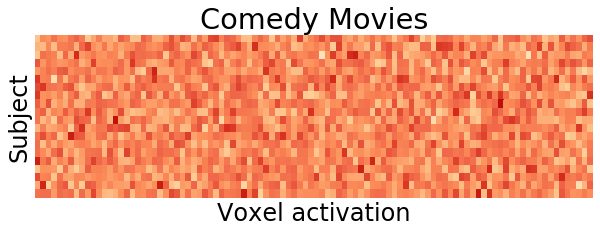

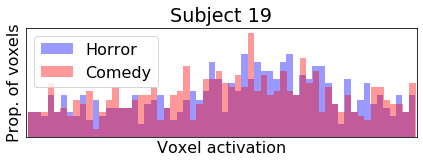

In [4]:
cond0 = np.mean([np.reshape(data[(data['cond']==0) & (data['run']==0)]['beta'].values,(num_subjects,num_voxels)),
                 np.reshape(data[(data['cond']==0) & (data['run']==1)]['beta'].values,(num_subjects,num_voxels)),
                 np.reshape(data[(data['cond']==0) & (data['run']==2)]['beta'].values,(num_subjects,num_voxels)),
                 np.reshape(data[(data['cond']==0) & (data['run']==3)]['beta'].values,(num_subjects,num_voxels)),
                 np.reshape(data[(data['cond']==0) & (data['run']==4)]['beta'].values,(num_subjects,num_voxels)),
                 np.reshape(data[(data['cond']==0) & (data['run']==5)]['beta'].values,(num_subjects,num_voxels))],
                axis=0)
cond1 = np.mean([np.reshape(data[(data['cond']==1) & (data['run']==0)]['beta'].values,(num_subjects,num_voxels)),
                 np.reshape(data[(data['cond']==1) & (data['run']==1)]['beta'].values,(num_subjects,num_voxels)),
                 np.reshape(data[(data['cond']==1) & (data['run']==2)]['beta'].values,(num_subjects,num_voxels)),
                 np.reshape(data[(data['cond']==1) & (data['run']==3)]['beta'].values,(num_subjects,num_voxels)),
                 np.reshape(data[(data['cond']==1) & (data['run']==4)]['beta'].values,(num_subjects,num_voxels)),
                 np.reshape(data[(data['cond']==1) & (data['run']==5)]['beta'].values,(num_subjects,num_voxels))],
                axis=0)
                 
cond0sub19 = data[(data['sub_num']==19) & (data['cond']==0)]['beta'].values
cond1sub19 = data[(data['sub_num']==19) & (data['cond']==1)]['beta'].values

with plt.rc_context(rc={'font.size': 24, 'figure.figsize': (10,3)}):
    sns.heatmap(cond0,vmin=-3,vmax=3,cmap="PuBu",cbar=False)
    plt.yticks([]);plt.xticks([])
    plt.ylabel('Subject')
    plt.xlabel('Voxel activation')
    plt.title('Horror Movies')
    plt.savefig("1a.png", dpi=250, transparent=True, bbox_inches="tight", pad_inches=0.1, format="png")
    plt.show()

    sns.heatmap(cond1,vmin=-3,vmax=3,cmap="OrRd",cbar=False)
    plt.yticks([]);plt.xticks([])
    plt.ylabel('Subject')
    plt.xlabel('Voxel activation')
    plt.title('Comedy Movies')
    plt.savefig("1b.png", dpi=250, transparent=True, bbox_inches="tight", pad_inches=0.1, format="png")
    plt.show()
    
with plt.rc_context(rc={'font.size': 16}):
    sns.distplot(cond0sub19,bins=60,kde=False,color='b',label="Horror") 
    sns.distplot(cond1sub19,bins=60,kde=False,color='r',label="Comedy") 
    plt.legend()
    plt.ylabel('Prop. of voxels')
    plt.xlabel('Voxel activation')
    plt.yticks([]);plt.xticks([])
    plt.xlim([-3,3])
    plt.title('Subject 19')
    plt.savefig("2a.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()

    sns.distplot(data[data['cond']==0]['beta'],bins=60,kde=False,color='b',label="Horror") 
    sns.distplot(data[data['cond']==1]['beta'],bins=60,kde=False,color='r',label="Comedy") 
    # plt.legend(bbox_to_anchor=(1, 0.5))
    plt.legend()
    plt.ylabel('Prop. of voxels')
    plt.xlabel('Voxel activation')
    plt.yticks([]);plt.xticks([])
    plt.xlim([-3,3])
    plt.title('All subjects')
    plt.savefig("2b.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()

For subject 19 only


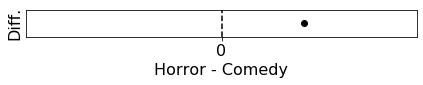

In [5]:
print("For subject 19 only")
with plt.rc_context(rc={'font.size': 16,'figure.figsize': (7,.5)}):
    plt.scatter(np.mean(data['beta'][(data['cond']==0)&(data['sub_num']==19)]),0,color='b',label="Horror") 
    plt.scatter(np.mean(data['beta'][(data['cond']==1)&(data['sub_num']==19)]),0,color='r',label="Comedy") 
    plt.ylabel('Avg.')
    plt.xlabel('Voxel activation')
    plt.yticks([]);plt.xticks([])
    plt.xlim([-3,3])
    plt.savefig("2c.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()
    
    plt.scatter(np.mean(data['beta'][(data['cond']==0)&(data['sub_num']==19)])+np.mean(data['beta'][(data['cond']==1)&(data['sub_num']==19)]),
                0,color='k') 
    plt.xlabel('Horror - Comedy')
    plt.ylabel('Diff.')
    plt.axvline(0,color='k',linestyle='--')
    plt.yticks([])
    plt.xticks([0])
    plt.xlim([-1,1])
#     plt.title('Subject 19')
    plt.savefig("2d.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()

All subjects


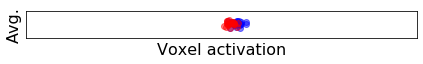

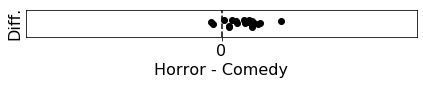

In [6]:
print("All subjects")
with plt.rc_context(rc={'font.size': 16, 'figure.figsize': (7,.5)}):
    jitters = np.random.rand(num_subjects*2)/10
    plt.scatter(data[data['cond']==0].groupby('sub_num')['beta'].mean(),
                jitters[:num_subjects],color='b',alpha=.5,label="Horror") 
    plt.scatter(data[data['cond']==1].groupby('sub_num')['beta'].mean(),
                jitters[num_subjects:],color='r',alpha=.5,label="Comedy") 
    plt.ylabel('Avg.')
    plt.xlabel('Voxel activation')
    plt.yticks([]);plt.xticks([])
    plt.xlim([-3,3])
    plt.savefig("2e.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()
    
    plt.scatter(data[data['cond']==0].groupby('sub_num')['beta'].mean()-data[data['cond']==1].groupby('sub_num')['beta'].mean(),
                jitters[:num_subjects],color='k') 
    plt.xlabel('Horror - Comedy')
    plt.ylabel('Diff.')
    plt.axvline(0,color='k',linestyle='--')
    plt.yticks([])
    plt.xticks([0])
    plt.xlim([-1,1])
#     plt.title('Subject 19')
    plt.savefig("2f.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()

In [209]:
# do statistics between conditions
a=np.mean(np.reshape(data[data['cond']==0]['beta'].values,(num_subjects,num_voxels*num_runs)),
          axis=1) # averaging voxels (in condition 0) for every subject
b=np.mean(np.reshape(data[data['cond']==1]['beta'].values,(num_subjects,num_voxels*num_runs)),
          axis=1) # averaging voxels (in condition 1) for every subject

with plt.rc_context(rc={'figure.figsize': (7,.5)}):
    sns.heatmap(np.flip(np.sort([a-b])),vmin=-1,vmax=1,cbar=False,cmap="RdBu")
    plt.ylabel("Diff.")
    plt.yticks([]);plt.xticks([])
#     plt.xticks(np.arange(.5,num_subjects+.5,1), np.arange(1,num_subjects+1), fontsize=12, rotation=0, ha="center")
    plt.xlabel("Subject")
    plt.title("Horror - Comedy")
    plt.savefig("3.png", dpi=250, transparent=True, bbox_inches="tight", pad_inches=0.1, format="png")
    plt.show()

stat = sp.stats.ttest_rel(a,b)
print("Horror vs. Comedy (paired t-test):\nt={:.4f}, p={:.4f}, d={:.4f}".format(
    stat.statistic,stat.pvalue,paired_cohen_d(a,b)))

Horror vs. Comedy (paired t-test):
t=5.6785, p=0.0000, d=1.2698


# Correlation-Based MVPA and Classifier-Based MVPA

## Visualize our data

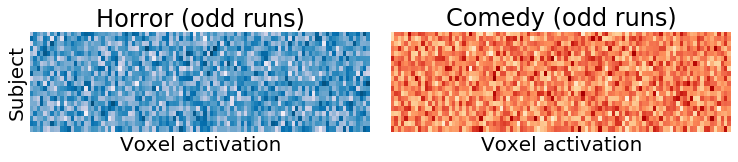

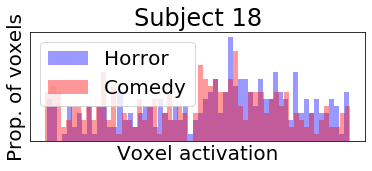

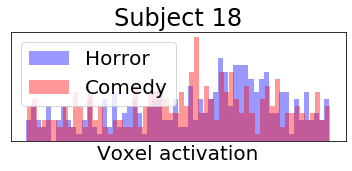

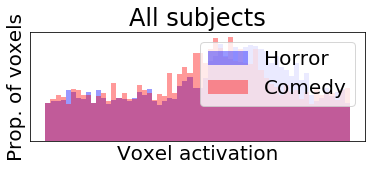

In [8]:
with plt.rc_context(rc={'font.size': 20, 'figure.figsize': (10,2)}):
    plt.subplot(1, 2, 1)
    sns.heatmap(np.mean(np.reshape(data[(data['cond']==0) & (data['oddeven']==0)].sort_values(by=["sub_num", "vox"])['beta'].values,(num_subjects,num_voxels,num_runs//2)),axis=2),
                vmin=-3,vmax=3,cmap="PuBu",cbar=False)
    plt.yticks([]);plt.xticks([])
    plt.ylabel('Subject')
    plt.xlabel('Voxel activation')
    plt.title('Horror (odd runs)')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(np.mean(np.reshape(data[(data['cond']==1) & (data['oddeven']==0)].sort_values(by=["sub_num", "vox"])['beta'].values,(num_subjects,num_voxels,num_runs//2)),axis=2),
                vmin=-3,vmax=3,cmap="OrRd",cbar=False)
    plt.yticks([]);plt.xticks([])
    plt.ylabel(' ')
    plt.xlabel('Voxel activation')
    plt.title('Comedy (odd runs)')
    plt.tight_layout(pad=-.1)
    plt.savefig("1a.png", dpi=250, transparent=True, bbox_inches="tight", pad_inches=0.1, format="png")
    plt.show()

    plt.subplot(1, 2, 1)
    sns.heatmap(np.mean(np.reshape(data[(data['cond']==0) & (data['oddeven']==1)].sort_values(by=["sub_num", "vox"])['beta'].values,(num_subjects,num_voxels,num_runs//2)),axis=2),
                vmin=-3,vmax=3,cmap="PuBu",cbar=False)
    plt.yticks([]);plt.xticks([])
    plt.ylabel('Subject')
    plt.xlabel('Voxel activation')
    plt.title('Horror (even runs)')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(np.mean(np.reshape(data[(data['cond']==1) & (data['oddeven']==1)].sort_values(by=["sub_num", "vox"])['beta'].values,(num_subjects,num_voxels,num_runs//2)),axis=2),
                vmin=-3,vmax=3,cmap="OrRd",cbar=False)
    plt.yticks([]);plt.xticks([])
    plt.ylabel(' ')
    plt.xlabel('Voxel activation')
    plt.title('Comedy (even runs)')
    plt.tight_layout(pad=-.1)
    plt.savefig("1b.png", dpi=250, transparent=True, bbox_inches="tight", pad_inches=0.1, format="png")
    plt.show()

with plt.rc_context(rc={'font.size': 20, 'figure.figsize': (6,2)}):
    sns.distplot(data['beta'][(data['cond']==0)&(data['sub_num']==18)&(data['oddeven']==0)],bins=60,kde=False,color='b',label="Horror") 
    sns.distplot(data['beta'][(data['cond']==1)&(data['sub_num']==18)&(data['oddeven']==0)],bins=60,kde=False,color='r',label="Comedy") 
    plt.legend()
    plt.ylabel('Prop. of voxels')
    plt.xlabel('Voxel activation')
    plt.yticks([]);plt.xticks([])
    plt.title('Subject 18')
    plt.savefig("2a.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()
    
    sns.distplot(data['beta'][(data['cond']==0)&(data['sub_num']==18)&(data['oddeven']==1)],bins=60,kde=False,color='b',label="Horror") 
    sns.distplot(data['beta'][(data['cond']==1)&(data['sub_num']==18)&(data['oddeven']==1)],bins=60,kde=False,color='r',label="Comedy") 
    plt.legend()
    plt.xlabel('Voxel activation')
    plt.yticks([]);plt.xticks([])
    plt.title('Subject 18')
    plt.savefig("2b.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()
    
    sns.distplot(data['beta'][(data['cond']==0)&(data['oddeven']==0)],bins=60,kde=False,color='b',label="Horror") 
    sns.distplot(data['beta'][(data['cond']==1)&(data['oddeven']==0)],bins=60,kde=False,color='r',label="Comedy") 
    plt.legend()
    plt.ylabel('Prop. of voxels')
    plt.xlabel('Voxel activation')
    plt.yticks([]);plt.xticks([])
    plt.title('All subjects')
    plt.savefig("2c.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()
    
    sns.distplot(data['beta'][(data['cond']==0)&(data['oddeven']==1)],bins=60,kde=False,color='b',label="Horror") 
    sns.distplot(data['beta'][(data['cond']==1)&(data['oddeven']==1)],bins=60,kde=False,color='r',label="Comedy") 
    plt.legend()
    plt.xlabel('Voxel activation')
    plt.yticks([]);plt.xticks([])
    plt.title('All subjects')
    plt.savefig("2d.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()


## Perform MVPA using correlation

In [202]:
# for each subject, correlate odd/even runs for each condition
corr = np.full((num_subjects,num_conditions*2),np.nan)
for s in range(num_subjects):
    for c in range(num_conditions*2):
        if c == 0: # cond0 (odd) -> cond0 (even)
            corr[s,c], _ = sp.stats.pearsonr(data[(data['cond']==0)&(data['oddeven']==0)&(data['sub_num']==s)].sort_values('vox')['beta'].values,
                                             data[(data['cond']==0)&(data['oddeven']==1)&(data['sub_num']==s)].sort_values('vox')['beta'].values)
        elif c == 1: # cond1 (odd) -> cond1 (even)
            corr[s,c], _ = sp.stats.pearsonr(data[(data['cond']==1)&(data['oddeven']==0)&(data['sub_num']==s)].sort_values('vox')['beta'].values,
                                             data[(data['cond']==1)&(data['oddeven']==1)&(data['sub_num']==s)].sort_values('vox')['beta'].values)
        elif c == 2: # cond0 (odd) -> cond1 (even)
            corr[s,c], _ = sp.stats.pearsonr(data[(data['cond']==0)&(data['oddeven']==0)&(data['sub_num']==s)].sort_values('vox')['beta'].values,
                                             data[(data['cond']==1)&(data['oddeven']==1)&(data['sub_num']==s)].sort_values('vox')['beta'].values)
        elif c == 3: # cond1 (odd) -> cond0 (even)
            corr[s,c], _ = sp.stats.pearsonr(data[(data['cond']==1)&(data['oddeven']==0)&(data['sub_num']==s)].sort_values('vox')['beta'].values,
                                             data[(data['cond']==0)&(data['oddeven']==1)&(data['sub_num']==s)].sort_values('vox')['beta'].values)
    
with plt.rc_context(rc={'font.size': 20, 'figure.figsize': (5,2)}):
    plt.imshow(corr, cmap='gray', aspect='auto')
    plt.ylabel('Subject')
    plt.yticks([]);
    plt.xticks(np.arange(4),["Horror\n(Odd)\nHorror\n(Even)","Comedy\n(Odd)\nComedy\n(Even)",
                             "Horror\n(Odd)\nComedy\n(Even)","Comedy\n(Odd)\nHorror\n(Even)"],
               fontsize=14, rotation=0, ha="center")
#     plt.xlabel('Correlation Condition')
    plt.colorbar()
    plt.show()

with plt.rc_context(rc={'font.size': 20, 'figure.figsize': (4,.5)}):
    plt.imshow([np.mean(corr,axis=0)], cmap='gray', aspect='auto')
    plt.ylabel('Avg.')
    plt.yticks([]); 
    plt.xticks(np.arange(4),["Horror\n(Odd)\nHorror\n(Even)","Comedy\n(Odd)\nComedy\n(Even)",
                             "Horror\n(Odd)\nComedy\n(Even)","Comedy\n(Odd)\nHorror\n(Even)"],
               fontsize=14, rotation=0, ha="center")
#     plt.xlabel('Correlation Condition')
    plt.savefig("4_2.png", dpi=50, transparent=True, bbox_inches="tight", pad_inches=0.1, format="png")
    plt.show()

print('From left to right:')
print('° cond0 (odd) & cond0 (even)     Avg. across subjects:  r={:.4f}'.format(np.mean(corr[:,0])))
print('° cond1 (odd) & cond1 (even)     Avg. across subjects:  r={:.4f}'.format(np.mean(corr[:,1])))
print('° cond0 (odd) & cond1 (even)     Avg. across subjects:  r={:.4f}'.format(np.mean(corr[:,2])))
print('° cond1 (odd) & cond0 (even)     Avg. across subjects:  r={:.4f}'.format(np.mean(corr[:,3])))

stat = sp.stats.ttest_rel(corr[:,:2].flatten(),corr[:,2:].flatten())
print("\nSignificantly different correlations betw first two columns and last two columns? (paired t-test):\nt={:.4f}, p={:.4f}, d={:.4f}".format(
    stat.statistic,stat.pvalue,paired_cohen_d(corr[:,:2].flatten(),corr[:,2:].flatten())))

From left to right:
° cond0 (odd) & cond0 (even)     Avg. across subjects:  r=0.0027
° cond1 (odd) & cond1 (even)     Avg. across subjects:  r=0.0330
° cond0 (odd) & cond1 (even)     Avg. across subjects:  r=-0.0236
° cond1 (odd) & cond0 (even)     Avg. across subjects:  r=-0.0101

Significantly different correlations betw first two columns and last two columns? (paired t-test):
t=2.4547, p=0.0187, d=0.3881


# Perform MVPA using classifier

In [207]:
scores=[];
for s in range(num_subjects): #num_subjects
    model = svm.SVC(kernel='linear')
    
    # sort into training and test (samples,features) = (num_runs*num_conditions*num_voxels,num_voxels)
    
    X_train = data[(data['run']%2==0)&(data['sub_num']==s)].sort_values(['cond','vox']).loc[:,['beta']].values
    X_train = X_train.reshape(num_runs//2*num_conditions,num_voxels)
    y_train = data[(data['run']%2==0)&(data['sub_num']==s)].sort_values(['cond','vox']).loc[:,['cond']].values
    y_train = y_train.reshape(num_runs//2*num_conditions,num_voxels)
    y_train = np.unique(y_train,axis=1)

    X_test = data[(data['run']%2==1)&(data['sub_num']==s)].sort_values(['cond','vox']).loc[:,['beta']].values
    X_test = X_test.reshape(num_runs//2*num_conditions,num_voxels)
    y_test = data[(data['run']%2==1)&(data['sub_num']==s)].sort_values(['cond','vox']).loc[:,['cond']].values
    y_test = y_test.reshape(num_runs//2*num_conditions,num_voxels)
    y_test = np.unique(y_test,axis=1)
    
#     for pair in itertools.combinations(range(num_voxels),2):
#         X_train.append([data['beta'][(data['cond']==0)&(data['run']==0)&(data['sub_num']==s)&(data['vox']==pair[0])].values[0],
#             data['beta'][(data['cond']==0)&(data['run']==0)&(data['sub_num']==s)&(data['vox']==pair[1])].values[0]])
#         X_train.append([data['beta'][(data['cond']==1)&(data['run']==0)&(data['sub_num']==s)&(data['vox']==pair[0])].values[0],
#             data['beta'][(data['cond']==1)&(data['run']==0)&(data['sub_num']==s)&(data['vox']==pair[1])].values[0]])
#         X_test.append([data['beta'][(data['cond']==0)&(data['run']==1)&(data['sub_num']==s)&(data['vox']==pair[0])].values[0],
#             data['beta'][(data['cond']==0)&(data['run']==1)&(data['sub_num']==s)&(data['vox']==pair[1])].values[0]])
#         X_test.append([data['beta'][(data['cond']==1)&(data['run']==1)&(data['sub_num']==s)&(data['vox']==pair[0])].values[0],
#             data['beta'][(data['cond']==1)&(data['run']==1)&(data['sub_num']==s)&(data['vox']==pair[1])].values[0]])
#         y_train.append([0]);y_train.append([1])
#         y_test.append([0]);y_test.append([1])
#     X_train=np.array(X_train);X_test=np.array(X_test)
#     y_train=np.array(y_train);y_test=np.array(y_test)
    model.fit(X_train,y_train)
#     print("score:",model.score(X_test,y_test))
    scores = np.concatenate([scores,[model.score(X_test,y_test)]])
plt.scatter(np.arange(len(scores)),scores)
print("avg across subs:",np.mean(scores))

avg across subs: 0.55


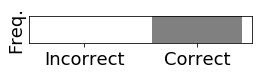

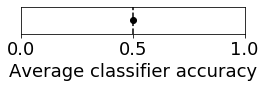

In [719]:
with plt.rc_context(rc={'font.size': 18,'figure.figsize': (4,.5)}):
    plt.bar([0,1],[np.sum(y==0),np.sum(y==1)],color=[.5,.5,.5])
    plt.yticks([]);plt.ylim([0,150])
    plt.ylabel("Freq.")
    plt.xticks([0,1],["Incorrect","Correct"])
    plt.savefig("6a.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()

with plt.rc_context(rc={'font.size': 18,'figure.figsize': (4,.5)}):
    plt.scatter(scores[0],0,color='k') 
    plt.xlabel('Average classifier accuracy')
    plt.yticks([]);plt.xticks([])
    plt.xlim([0,1])
    plt.axvline(0.5,color='k',linestyle='--')
    plt.xticks([0,0.5,1])
    plt.savefig("6b.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()

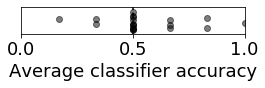

In [208]:
jitters = np.random.rand(num_subjects*2)/5
with plt.rc_context(rc={'font.size': 18,'figure.figsize': (4,.5)}):
    for s in range(num_subjects):
        plt.scatter(scores[s],jitters[s],color='k',alpha=.5) 
    plt.xlabel('Average classifier accuracy')
    plt.yticks([]);plt.xticks([])
    plt.xlim([0,1])
    plt.axvline(.5,color='k',linestyle='--')
    plt.xticks([0,.5,1])
    plt.savefig("6c.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()

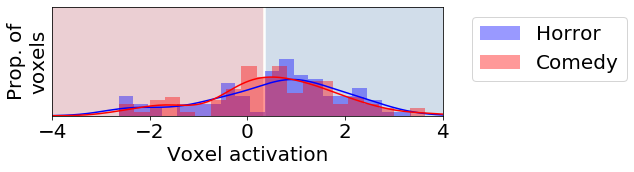

In [622]:
for s in range(num_subjects):
    model = svm.SVC(kernel='linear')
    X_train = data['beta'][(data['run']==0)&(data['sub_num']==s)].values.reshape(-1, 1)
    X_test = data['beta'][(data['run']==1)&(data['sub_num']==s)].values.reshape(-1, 1)
    y_train = data['cond'][(data['run']==0)&(data['sub_num']==s)].values.reshape(-1, 1)
    y_test = data['cond'][(data['run']==1)&(data['sub_num']==s)].values.reshape(-1, 1)
    model.fit(X_train,y_train)
    if s==18:
        y = np.concatenate([np.repeat(0,int(200*(1-yscore))),np.repeat(1,int(200*yscore))])
        yscore = model.score(X_test,y_test)
    scores = np.concatenate([scores,[model.score(X_test,y_test)]])

    if s==18:
        X=X_train
        y=y_train
        xx, yy = np.meshgrid(np.arange(-4, 4.1, 0.1),
                             np.arange(0, 1, 0.1))
        Z = model.predict(np.c_[xx.ravel()])
        Z = Z.reshape(xx.shape)

        # plot dist
        plt.contourf(xx, yy, -Z, alpha=0.2,cmap="RdBu")
        sns.distplot(X[y==0],
                     bins=20,color='b',label="Horror") 
        sns.distplot(X[y==1],
                     bins=20,color='r',label="Comedy") 
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.xlim([xx.min(),xx.max()])
        plt.yticks([])
        plt.ylabel('Prop. of\nvoxels')
        plt.xlabel('Voxel activation')
        plt.savefig("6.png", dpi=50, transparent=True,bbox_inches="tight", pad_inches=0.1, format="png")
        plt.show()    
        
        X=X_test
        y=y_test
        Z = model.predict(np.c_[xx.ravel()])
        Z = Z.reshape(xx.shape)

        # plot dist
        plt.contourf(xx, yy, -Z, alpha=0.2,cmap="RdBu")
        sns.distplot(X[y==0],
                     bins=20,color='b',label="Horror") 
        sns.distplot(X[y==1],
                     bins=20,color='r',label="Comedy") 
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.xlim([xx.min(),xx.max()])
        plt.yticks([])
        plt.ylabel('Prop. of\nvoxels')
        plt.xlabel('Voxel activation')
        plt.savefig("6.png", dpi=50, transparent=True,bbox_inches="tight", pad_inches=0.1, format="png")
        plt.show()  

In [701]:
for s in range(num_subjects):
    model = svm.SVC(kernel='linear')
    X_train = np.c_[data['beta'][(data['cond']==0)&(data['run']==0)&(data['sub_num']==s)].values,
                    data['beta'][(data['cond']==1)&(data['run']==0)&(data['sub_num']==s)].values].T
    X_test = np.c_[data['beta'][(data['cond']==0)&(data['run']==1)&(data['sub_num']==s)].values,
                    data['beta'][(data['cond']==1)&(data['run']==1)&(data['sub_num']==s)].values].T
    y_train,y_test = [0,1],[0,1]
    model.fit(X_train,y_train)
    if s==18:
        y = np.concatenate([np.repeat(0,int(200*(1-yscore))),np.repeat(1,int(200*yscore))])
        yscore = model.score(X_test,y_test)
    scores = np.concatenate([scores,[model.score(X_test,y_test)]])

    if s==18:
        X=X_train
        y=y_train
        xx, yy = np.meshgrid(np.arange(-4, 4.1, 0.1),
                             np.arange(0, 1, 0.1))
        Z = model.predict(np.c_[xx.ravel()])
        Z = Z.reshape(xx.shape)

        # plot dist
        plt.contourf(xx, yy, -Z, alpha=0.2,cmap="RdBu")
        sns.distplot(X[y==0],
                     bins=20,color='b',label="Horror") 
        sns.distplot(X[y==1],
                     bins=20,color='r',label="Comedy") 
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.xlim([xx.min(),xx.max()])
        plt.yticks([])
        plt.ylabel('Prop. of\nvoxels')
        plt.xlabel('Voxel activation')
        plt.savefig("6.png", dpi=50, transparent=True,bbox_inches="tight", pad_inches=0.1, format="png")
        plt.show()    
        
        X=X_test
        y=y_test
        Z = model.predict(np.c_[xx.ravel()])
        Z = Z.reshape(xx.shape)

        # plot dist
        plt.contourf(xx, yy, -Z, alpha=0.2,cmap="RdBu")
        sns.distplot(X[y==0],
                     bins=20,color='b',label="Horror") 
        sns.distplot(X[y==1],
                     bins=20,color='r',label="Comedy") 
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.xlim([xx.min(),xx.max()])
        plt.yticks([])
        plt.ylabel('Prop. of\nvoxels')
        plt.xlabel('Voxel activation')
        plt.savefig("6.png", dpi=50, transparent=True,bbox_inches="tight", pad_inches=0.1, format="png")
        plt.show()  

ValueError: X.shape[1] = 1 should be equal to 100, the number of features at training time

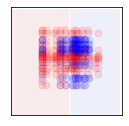

In [477]:
s=18
X_train = data['beta'][(data['run']==0)&(data['sub_num']==s)].values.reshape(-1, 1)
X_test = data['beta'][(data['run']==1)&(data['sub_num']==s)].values.reshape(-1, 1)
y_train = data['cond'][(data['run']==0)&(data['sub_num']==s)].values.reshape(-1, 1)
y_test = data['cond'][(data['run']==1)&(data['sub_num']==s)].values.reshape(-1, 1)

with plt.rc_context(rc={'font.size': 14, 'figure.figsize': (2,2)}):  
    model = svm.SVC(kernel='linear')
    model.fit(X_train,y_train)

    xx, yy = np.meshgrid(np.arange(-5, 5, .2),
                         np.arange(-5, 5, .2))
    Z = model.predict(xx.reshape(-1, 1))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=.1)

    for pair in itertools.combinations(range(100), 2):
        plt.scatter(X_train[y_train==0][pair[0]]
                    ,X_train[y_train==0][pair[1]]
                    ,50,color='b',alpha=.1)
        plt.scatter(X_train[y_train==1][pair[0]]
                    ,X_train[y_train==1][pair[1]]
                    ,50,color='r',alpha=.1)
    plt.xticks([]);plt.yticks([])
    plt.xlim([-5,5]);plt.ylim([-5,5]);
    plt.savefig("8_1.png", dpi=250, transparent=True, bbox_inches="tight", pad_inches=0.1, format="png")
    plt.show()